# Covid prediction model

In [102]:
import pandas as pd
from pandasql import sqldf
import glob
pysqldf = lambda q: sqldf(q, globals())

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support as score

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## 0. Clean data

fetch data from https://covidclinicaldata.org/ 

In [38]:
all_files = glob.glob('/Users/zhuochen/Downloads/covidclinicaldata-master/data/*.csv')
df = pd.concat((pd.read_csv(f) for f in all_files)).reset_index()

exploratory data analysis

In [39]:
df.head()

,index,batch_date,test_name,swab_type,covid19_test_results,age,high_risk_exposure_occupation,high_risk_interactions,diabetes,chd,htn,cancer,asthma,copd,autoimmune_dis,smoker,temperature,pulse,sys,dia,rr,sats,rapid_flu_results,rapid_strep_results,ctab,labored_respiration,rhonchi,wheezes,days_since_symptom_onset,cough,cough_severity,fever,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat,cxr_findings,cxr_impression,cxr_label,cxr_link,er_referral
0,0,2020-06-16,"SARS-CoV-2, NAA",Nasal,Negative,15,False,False,False,False,False,False,False,False,False,False,37.00,74.0,123.0,80.0,17.0,99.0,NaN,NaN,False,False,False,False,NaN,False,NaN,False,False,NaN,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,False
1,1,2020-06-16,SARS COV2 NAAT,Nasopharyngeal,Negative,20,False,False,False,False,False,False,False,False,False,False,36.75,88.0,105.0,73.0,12.0,96.0,NaN,NaN,True,False,True,True,NaN,False,NaN,False,False,NaN,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,False
2,2,2020-06-16,"SARS-CoV-2, NAA",Nasal,Negative,14,False,NaN,False,False,False,False,False,False,False,False,36.95,83.0,138.0,61.0,18.0,99.0,NaN,NaN,False,False,NaN,NaN,NaN,False,NaN,False,False,NaN,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,False
3,3,2020-06-16,"SARS-CoV-2, NAA",Nasopharyngeal,Negative,32,False,False,False,False,False,False,False,False,False,False,36.85,88.0,160.0,99.0,12.0,99.0,NaN,NaN,False,NaN,NaN,NaN,NaN,False,NaN,False,False,NaN,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,False
4,4,2020-06-16,"SARS-CoV-2, NAA",Nasal,Negative,29,False,True,False,False,False,False,False,False,False,False,37.00,82.0,111.0,74.0,17.0,99.0,NaN,NaN,False,NaN,NaN,False,3.0,False,NaN,False,False,NaN,False,True,True,False,False,False,False,False,NaN,NaN,NaN,NaN,False


In [41]:
df['age'].dtype

dtype('int64')

In [42]:
df['age'].describe()

count    93995.00000
mean        39.17569
std         15.03687
min         -3.00000
25%         28.00000
50%         37.00000
75%         50.00000
max         91.00000
Name: age, dtype: float64

In [43]:
df['swab_type'].value_counts()

Nasal              77732
Nasopharyngeal      9169
Mid Turbinate       5673
Saliva               853
Oropharyngeal        474
anterior nares        58
Anterior nares        24
mid turbinate          1
anterior narws         1
XRT                    1
Anterior nares         1
ANTERIOR NARES         1
anterior nasl          1
anterior nassal        1
anterior               1
anterior naal          1
anterior nars          1
anterior mares         1
anterior               1
Name: swab_type, dtype: int64

In [45]:
df['pulse'].isna().sum()

45716

In [47]:
df['pulse'].isna().sum() / len(df)  # df.shape[0]

0.4863662960795787

In [48]:
df.columns

Index(['index', 'batch_date', 'test_name', 'swab_type', 'covid19_test_results',
       'age', 'high_risk_exposure_occupation', 'high_risk_interactions',
       'diabetes', 'chd', 'htn', 'cancer', 'asthma', 'copd', 'autoimmune_dis',
       'smoker', 'temperature', 'pulse', 'sys', 'dia', 'rr', 'sats',
       'rapid_flu_results', 'rapid_strep_results', 'ctab',
       'labored_respiration', 'rhonchi', 'wheezes', 'days_since_symptom_onset',
       'cough', 'cough_severity', 'fever', 'sob', 'sob_severity', 'diarrhea',
       'fatigue', 'headache', 'loss_of_smell', 'loss_of_taste', 'runny_nose',
       'muscle_sore', 'sore_throat', 'cxr_findings', 'cxr_impression',
       'cxr_label', 'cxr_link', 'er_referral'],
      dtype='object')

<AxesSubplot:>

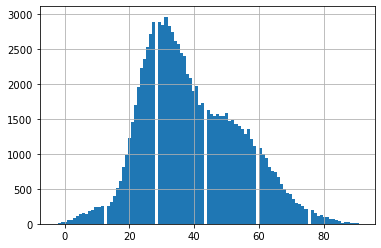

In [52]:
df['age'].hist(bins=100)

In [54]:
df_indicators = df[[
    'covid19_test_results',
    'temperature',
    'high_risk_exposure_occupation',
    'high_risk_interactions',
    'labored_respiration',
    'rhonchi',
    'cough',
    'cough_severity',
    'fever',
    'sob',
    'sob_severity',
    'diarrhea',
    'fatigue',
    'headache',
    'loss_of_smell', 
    'loss_of_taste', 
    'runny_nose', 
    'muscle_sore', 
    'sore_throat',
    'wheezes']]

In [55]:
df_indicators.tail()

,covid19_test_results,temperature,high_risk_exposure_occupation,high_risk_interactions,labored_respiration,rhonchi,cough,cough_severity,fever,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat,wheezes
93990,Negative,36.70,True,False,False,False,False,NaN,False,True,Mild,False,False,False,False,False,True,False,True,False
93991,Negative,36.70,False,False,False,False,False,NaN,False,False,NaN,False,False,False,False,False,False,False,False,False
93992,Negative,36.90,False,False,False,False,False,NaN,False,False,NaN,False,False,False,False,False,False,False,False,False
93993,Negative,36.45,False,False,NaN,NaN,False,NaN,False,False,NaN,False,False,False,False,False,False,False,False,NaN
93994,Negative,36.85,False,NaN,False,True,False,NaN,NaN,False,NaN,False,False,False,False,False,False,False,False,True


In [56]:
df_indicators.shape

(93995, 20)

In [57]:
df_indicators.shape[0]

93995

In [58]:
df_indicators.isna().sum()

covid19_test_results                 0
temperature                      46453
high_risk_exposure_occupation      169
high_risk_interactions           24827
labored_respiration              45248
rhonchi                          70651
cough                               15
cough_severity                   88284
fever                            22921
sob                                206
sob_severity                     91159
diarrhea                           187
fatigue                            176
headache                           183
loss_of_smell                      190
loss_of_taste                      190
runny_nose                         187
muscle_sore                        182
sore_throat                        183
wheezes                          66507
dtype: int64

In [59]:
len(df_indicators.dropna())

514

In [60]:
df_indicators.dropna().head(5)

,covid19_test_results,temperature,high_risk_exposure_occupation,high_risk_interactions,labored_respiration,rhonchi,cough,cough_severity,fever,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat,wheezes
130,Negative,36.95,True,False,False,True,True,Moderate,False,True,Mild,False,False,False,False,False,False,False,False,True
322,Negative,37.00,False,False,False,False,True,Moderate,True,True,Moderate,True,True,True,False,False,True,True,True,False
421,Negative,36.50,False,False,False,False,True,Mild,False,False,Mild,False,False,False,False,False,False,False,False,False
422,Negative,36.50,False,False,False,True,True,Moderate,False,True,Moderate,False,True,False,False,False,False,True,False,True
517,Negative,36.85,False,False,False,False,True,Moderate,True,True,Moderate,False,True,False,False,False,False,False,False,True


In [34]:
all_files = glob.glob('test_data/*.csv')
df = pd.concat((pd.read_csv(f) for f in all_files), sort = False)

In [63]:
df_indicators['cough_severity'].value_counts()

Mild        3966
Moderate    1627
Severe       118
Name: cough_severity, dtype: int64

In [66]:
df_indicators['cough_severity'] = pd.factorize(df_indicators['cough_severity'], na_sentinel=-1)[0]
df_indicators['sob_severity'] = pd.factorize(df_indicators['sob_severity'], na_sentinel=-1)[0]
df_indicators['covid19_test_results'] = pd.factorize(df_indicators['covid19_test_results'], na_sentinel=-1)[0]

In [67]:
len(df_indicators.dropna())

19462

In [69]:
df_indicators['cough_severity'].value_counts()

0    88284
1     3966
2     1627
3      118
Name: cough_severity, dtype: int64

In [72]:
df_indicators.fillna(0).head(100)

,covid19_test_results,temperature,high_risk_exposure_occupation,high_risk_interactions,labored_respiration,rhonchi,cough,cough_severity,fever,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat,wheezes
0,0,37.00,False,False,False,False,False,0,False,False,0,False,False,False,False,False,False,False,False,False
1,0,36.75,False,False,False,True,False,0,False,False,0,False,False,False,False,False,False,False,False,True
2,0,36.95,False,0,False,0,False,0,False,False,0,False,False,False,False,False,False,False,False,0
3,0,36.85,False,False,0,0,False,0,False,False,0,False,False,False,False,False,False,False,False,0
4,0,37.00,False,True,0,0,False,0,False,False,0,False,True,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,36.80,False,False,False,False,False,0,False,False,0,False,False,False,False,False,False,False,False,False
96,0,37.30,False,False,False,0,True,2,False,True,2,False,True,True,False,False,False,False,True,0
97,0,36.95,False,False,False,True,False,0,0,False,0,False,False,False,False,False,False,False,False,True
98,0,36.50,False,False,False,False,False,0,0,False,0,False,False,True,False,False,False,False,False,False


In [73]:
df_indicators.fillna(0, inplace=True)

In [75]:
df_indicators.head()

,covid19_test_results,temperature,high_risk_exposure_occupation,high_risk_interactions,labored_respiration,rhonchi,cough,cough_severity,fever,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat,wheezes
0,0,37.00,False,False,False,False,False,0,False,False,0,False,False,False,False,False,False,False,False,False
1,0,36.75,False,False,False,True,False,0,False,False,0,False,False,False,False,False,False,False,False,True
2,0,36.95,False,0,False,0,False,0,False,False,0,False,False,False,False,False,False,False,False,0
3,0,36.85,False,False,0,0,False,0,False,False,0,False,False,False,False,False,False,False,False,0
4,0,37.00,False,True,0,0,False,0,False,False,0,False,True,True,False,False,False,False,False,False


In [74]:
df_indicators.describe()

,covid19_test_results,temperature,cough_severity,sob_severity
count,93995.000000,93995.000000,93995.000000,93995.000000
mean,0.013969,18.610529,0.080579,0.044619
std,0.117362,18.397395,0.340937,0.272407
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,36.100000,0.000000,0.000000
75%,0.000000,36.800000,0.000000,0.000000
max,1.000000,39.600000,3.000000,3.000000


In [76]:
df_indicators = df_indicators * 1

In [77]:
df_indicators.head(100)

,covid19_test_results,temperature,high_risk_exposure_occupation,high_risk_interactions,labored_respiration,rhonchi,cough,cough_severity,fever,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat,wheezes
0,0,37.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,36.75,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,36.95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,36.85,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,37.00,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,36.80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
96,0,37.30,0,0,0,0,1,2,0,1,2,0,1,1,0,0,0,0,1,0
97,0,36.95,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
98,0,36.50,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [80]:
df_indicators.to_csv('./test_data/results_symptoms.csv', index=False)

(32.0, 42.0)

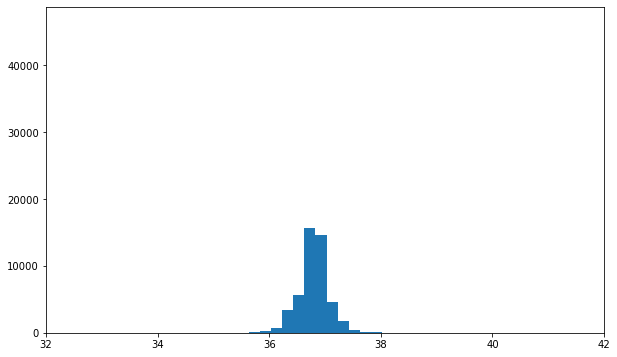

In [94]:
plt.figure(figsize=(10, 6))
plt.hist(df_indicators['temperature'], bins=200)
plt.xlim([32, 42])

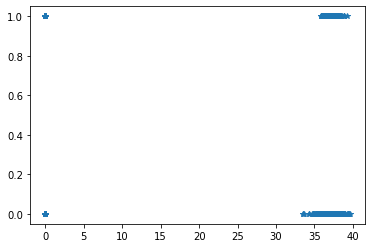

In [96]:
plt.plot(df_indicators['temperature'], df_indicators['covid19_test_results'], '*')

# 1. Modeling

In [98]:
df_symptoms = pd.read_csv('./test_data/results_symptoms.csv')

In [99]:
len(df_symptoms)

93995

In [100]:
df_symptoms.columns

Index(['covid19_test_results', 'temperature', 'high_risk_exposure_occupation',
       'high_risk_interactions', 'labored_respiration', 'rhonchi', 'cough',
       'cough_severity', 'fever', 'sob', 'sob_severity', 'diarrhea', 'fatigue',
       'headache', 'loss_of_smell', 'loss_of_taste', 'runny_nose',
       'muscle_sore', 'sore_throat', 'wheezes'],
      dtype='object')

In [101]:
df_symptoms.describe()

,covid19_test_results,temperature,high_risk_exposure_occupation,high_risk_interactions,labored_respiration,rhonchi,cough,cough_severity,fever,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat,wheezes
count,93995.000000,93995.000000,93995.000000,93995.000000,93995.000000,93995.000000,93995.000000,93995.000000,93995.000000,93995.000000,93995.000000,93995.000000,93995.000000,93995.000000,93995.000000,93995.000000,93995.000000,93995.000000,93995.000000,93995.000000
mean,0.013969,18.610529,0.073770,0.151231,0.004128,0.075398,0.062184,0.080579,0.021533,0.030236,0.044619,0.020182,0.065025,0.057673,0.007054,0.007192,0.036800,0.036066,0.062854,0.101442
std,0.117362,18.397395,0.261397,0.358276,0.064116,0.264033,0.241491,0.340937,0.145154,0.171236,0.272407,0.140623,0.246571,0.233126,0.083689,0.084500,0.188271,0.186455,0.242702,0.301914
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,36.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,36.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,39.600000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [103]:
df_symptoms.head()

,covid19_test_results,temperature,high_risk_exposure_occupation,high_risk_interactions,labored_respiration,rhonchi,cough,cough_severity,fever,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat,wheezes
0,0,37.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,36.75,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,36.95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,36.85,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,37.00,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0


In [104]:
df_symptoms["id"] = df_symptoms.index

In [105]:
df_symptoms.head()

,covid19_test_results,temperature,high_risk_exposure_occupation,high_risk_interactions,labored_respiration,rhonchi,cough,cough_severity,fever,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat,wheezes,id
0,0,37.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,36.75,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2,0,36.95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,0,36.85,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
4,0,37.00,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,4


In [106]:
df_symptoms.iloc[:,1:-1].head()

,temperature,high_risk_exposure_occupation,high_risk_interactions,labored_respiration,rhonchi,cough,cough_severity,fever,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat,wheezes
0,37.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,36.75,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,36.95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,36.85,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,37.00,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0


In [107]:
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
# for random forest, we don't need a scaler

symptom_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier())
    ])

In [108]:
symptom_clf.fit(df_symptoms.iloc[:,2:-1], df_symptoms['covid19_test_results'])

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', RandomForestClassifier())])

In [109]:
symptom_clf['clf'].feature_importances_

array([0.05931726, 0.07139746, 0.01218231, 0.02534821, 0.0453591 ,
       0.10410495, 0.06427116, 0.04108252, 0.06040852, 0.05193463,
       0.06119027, 0.05757815, 0.08260128, 0.06148781, 0.05433978,
       0.05310512, 0.06271678, 0.03157469])

In [110]:
feature_df = pd.DataFrame({'feature':df_symptoms.columns[2:-1], 
                           'importance': symptom_clf['clf'].feature_importances_})

In [111]:
feature_df.head()

,feature,importance
0,high_risk_exposure_occupation,0.059317
1,high_risk_interactions,0.071397
2,labored_respiration,0.012182
3,rhonchi,0.025348
4,cough,0.045359


In [112]:
pysqldf("SELECT * FROM feature_df ORDER BY importance DESC")

,feature,importance
0,cough_severity,0.104105
1,loss_of_smell,0.082601
2,high_risk_interactions,0.071397
3,fever,0.064271
4,sore_throat,0.062717
5,loss_of_taste,0.061488
6,fatigue,0.061190
7,sob_severity,0.060409
8,high_risk_exposure_occupation,0.059317
9,headache,0.057578


In [113]:
symptom_scores = cross_val_score(symptom_clf, df_symptoms.iloc[:,2:-1], df_symptoms['covid19_test_results'], cv=5)

feature importance plot